In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import emoji 
import re
import spacy
from wordcloud import WordCloud
import squarify

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [26]:
bitcoin = pd.read_csv('bitcoin.csv')

In [27]:
solana = pd.read_csv('solana.csv')

### DATA CLEANING

In [28]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_utc  988 non-null    float64
 1   title        988 non-null    object 
 2   self_text    738 non-null    object 
 3   subreddit    988 non-null    object 
dtypes: float64(1), object(3)
memory usage: 31.0+ KB


In [29]:
solana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_utc  914 non-null    float64
 1   title        914 non-null    object 
 2   self_text    824 non-null    object 
 3   subreddit    914 non-null    object 
dtypes: float64(1), object(3)
memory usage: 28.7+ KB


In [30]:
bitcoin.isna().sum()

created_utc      0
title            0
self_text      250
subreddit        0
dtype: int64

In [31]:
solana.isna().sum()

created_utc     0
title           0
self_text      90
subreddit       0
dtype: int64

In [32]:
#Filling null values for bitcoin. Filling them with an empty string as i'm going to merge the title and text later on
bitcoin.fillna('', inplace= True)

In [33]:
#Filling null values for bitcoin
solana.fillna('', inplace= True)

Checking for duplicates

In [34]:
bitcoin.duplicated(['self_text']).sum()

250

In [35]:
solana.duplicated().sum()

0

In [36]:
#pd.set_option('display.max_rows', None)

In [37]:
duplicate_rows = bitcoin[bitcoin.duplicated(['self_text'], keep=False)]
duplicate_rows

,created_utc,title,self_text,subreddit
0,1.712352e+09,USD vs Chinas CBDC,,Bitcoin
10,1.712345e+09,Managing UTXOs with Unchained Vaults and Caravan,,Bitcoin
11,1.712344e+09,The Greatest Bitcoin Explanation of ALL TIME,,Bitcoin
13,1.712342e+09,Trying to understand- in bitcoin world how fra...,,Bitcoin
23,1.712331e+09,Max schooling Pete (classic),,Bitcoin
...,...,...,...,...
974,1.711388e+09,"🎬 In the 2022 movie “Gold” starring Zac Efron,...",,Bitcoin
975,1.711386e+09,Seems fitting to amp this sub a bit with this ...,,Bitcoin
976,1.711386e+09,Bitcoin Hype Song (German) - Fan Song - AI Music,,Bitcoin
984,1.711380e+09,"I spent $569,481.80 on 1oz of pure MDMA from S...",,Bitcoin


After inspecting duplicated rows in the bitcoin data frame, there is only two rows that are duplicated (162 and 723). Removing row 723. The remainder rows that show as duplicate are empty rows. I want to keep these rows because I will merge them later with the titles. 

In [38]:
bitcoin = bitcoin.drop(723)

In [39]:
bitcoin.duplicated(['self_text']).sum()

249

Creating a function to clean my text and reduce words to their base form.

In [40]:
nlp = spacy.load('en_core_web_sm')

In [41]:
def preprocess_text_with_spacy(text):
    text_no_urls = re.sub(r'http\S+', '', text)   # remove URLs
    
    text_no_emojis = ''.join(char for char in text_no_urls if char not in emoji.EMOJI_DATA) # remove emojis 
    
    doc = nlp(text_no_emojis)    # Load the text into spacy

    custom_lemmas = {"etfs": "etf"}  # had to change the function to make sure it was lemmatizing this word accordingly
    
    doc = nlp(text_no_emojis)    # Load the text into spaCy
    
    lemma_tokens = []
    for token in doc:
        if not token.is_punct and not token.is_stop and len(token.text) > 1:     #change text to lower case, lemmatize, remove punctuation, stopwords and exclude single-character tokens
            lemma = token.lemma_.lower()
            # Check for custom lemmatization rules
            if lemma in custom_lemmas:
                lemma = custom_lemmas[lemma]
            lemma_tokens.append(lemma)
  
    text_lemmatized = ' '.join(lemma_tokens)      # join the lemmatized tokens into a string
    
    text_no_newline = text_lemmatized.replace('\n', ' ')    # remove \n characters
    
    text_cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text_no_newline)   # remove special characters 
    
    text_cleaned = ' '.join(text_cleaned.split())   # remove extra white spaces
    
    return text_cleaned

In [42]:
# Apply function to dataframes 

In [43]:
bitcoin['title'] = bitcoin['title'].apply(preprocess_text_with_spacy)
bitcoin['self_text'] = bitcoin['self_text'].apply(preprocess_text_with_spacy)

In [44]:
# changing bitcoin subreddit to lower case 
bitcoin['subreddit'] = bitcoin['subreddit'].str.lower()

In [45]:
bitcoin.head()

,created_utc,title,self_text,subreddit
0,1.712352e+09,usd vs chinas cbdc,,bitcoin
1,1.712352e+09,understand,post post read understand perception bitcoin s...,bitcoin
2,1.712351e+09,sell stock roth ira use buy bitcoin,hi 21 year old male plan invest bitcoin 10 yea...,bitcoin
3,1.712351e+09,bitcoin tax help,new bitcoin buy skincare idea have pay additio...,bitcoin
4,1.712348e+09,good way auto buy,use strike bitcoin atm find little stressed th...,bitcoin


In [46]:
solana['title'] = solana['title'].apply(preprocess_text_with_spacy)
solana['self_text'] = solana['self_text'].apply(preprocess_text_with_spacy)

In [47]:
solana.head()

,created_utc,title,self_text,subreddit
0,1.712353e+09,trading perp jupiter yall like,congestion suck,solana
1,1.712352e+09,solana comeback,network decongested transaction start approval...,solana
2,1.712351e+09,pende transaction,try look pende transaction detail solscan show...,solana
3,1.712351e+09,network congestion solution way,,solana
4,1.712351e+09,solana bitcoin,moment well 384 solana bitcoin,solana


In [48]:
# Concadenate DataFrames 
new_df = pd.concat([bitcoin, solana], axis = 0, ignore_index=False)

In [49]:
# joining title and text columns 
new_df['title_text'] = new_df['title'] + ' ' + new_df['self_text']

In [50]:
# drop columns that are not needed
new_df = new_df.drop(columns= ['created_utc','title', 'self_text'], axis=1)

After a thorough examination of the DataFrame, it appears that certain rows lack both a title and accompanying text. Consequently, when merging, these rows are represented by empty space. These instances occur within rows 59, 338, and 428. 

In [51]:
# removing those rows
new_df.drop([59, 338, 428], inplace=True)

In [52]:
# Checking for trailing spaces
subreddit_trailing = (new_df['subreddit'].str.len() != new_df['subreddit'].str.strip().str.len()).sum()
text_trailing = (new_df['title_text'].str.len() != new_df['title_text'].str.strip().str.len()).sum()

print(subreddit_trailing)
print(text_trailing)

0
354


In [53]:
# removing trailing spaces 
new_df['title_text'] = new_df['title_text'].str.strip()

In [54]:
# saving cleaned DataFrame to csv
#new_df.to_csv('reddit_clean.csv', index = False)

### EDA

Checking most common words in each subreddit

In [55]:
bitcoin_text = new_df[new_df['subreddit'] == 'bitcoin']['title_text']
solana_text = new_df[new_df['subreddit'] == 'solana']['title_text']

In [56]:
# most common words on bitcoin subreddit 

In [57]:
all_text = ' '.join(bitcoin_text)
words = all_text.split()

In [58]:
word_count_bitcoin = pd.Series(words).value_counts()

In [59]:
# checking the 20 most commond words for Bitcoin 
common_words_bitcoin = word_count_bitcoin.sort_values(ascending=False).head(20)
common_words_bitcoin

bitcoin     1385
btc          524
buy          317
wallet       309
like         276
people       227
year         212
time         210
know         208
money        195
value        185
sell         185
think        182
price        180
want         172
go           171
currency     154
good         154
use          138
need         130
Name: count, dtype: int64

In [60]:
# most common words on solana subreddit 

In [61]:
all_text = ' '.join(solana_text)
words = all_text.split()

In [62]:
word_count_solana = pd.Series(words).value_counts()

In [63]:
# checking the 20 most commond words for Solana
common_words_solana = word_count_solana.sort_values(ascending=False).head(20)
common_words_solana

solana         833
coin           491
wallet         469
token          428
sol            417
like           251
buy            235
meme           229
transaction    197
know           189
new            188
try            185
project        183
want           173
good           163
create         162
phantom        160
time           159
get            157
help           149
Name: count, dtype: int64

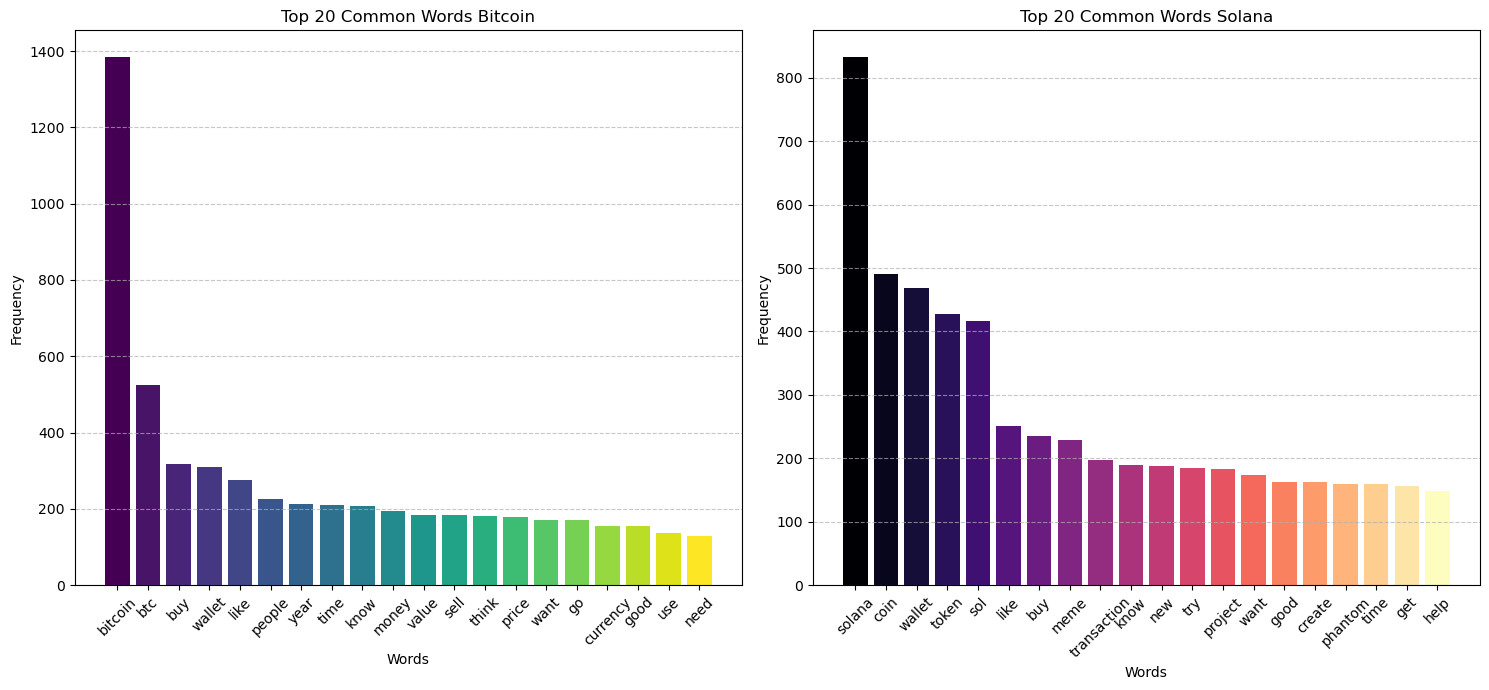

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

colormap = plt.cm.viridis 
colormap1 = plt.cm.magma

# Plotting bitcoin common words 
axes[0].bar(common_words_bitcoin.index, common_words_bitcoin.values, color=colormap(np.linspace(0, 1, len(common_words_bitcoin))))
axes[0].set_title('Top 20 Common Words Bitcoin')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plotting solana common words
axes[1].bar(common_words_solana.index, common_words_solana.values, color=colormap1(np.linspace(0, 1, len(common_words_solana))))
axes[1].set_title('Top 20 Common Words Solana')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [65]:
# Function to generate word cloud
def generate_word_cloud(words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

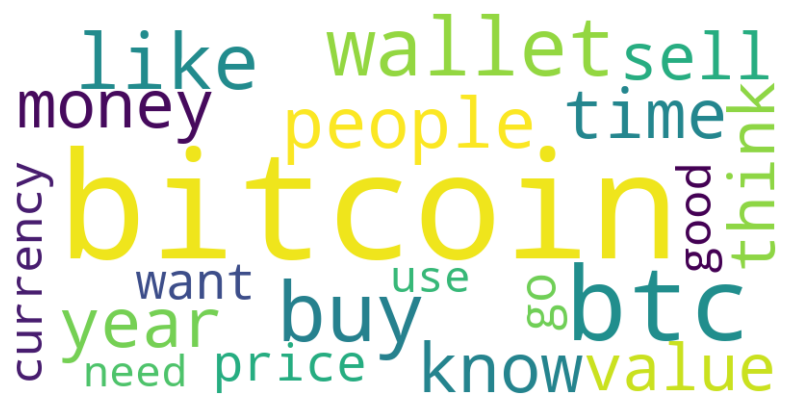

In [97]:
# Bitcoin's word cloud
generate_word_cloud(common_words_bitcoin)

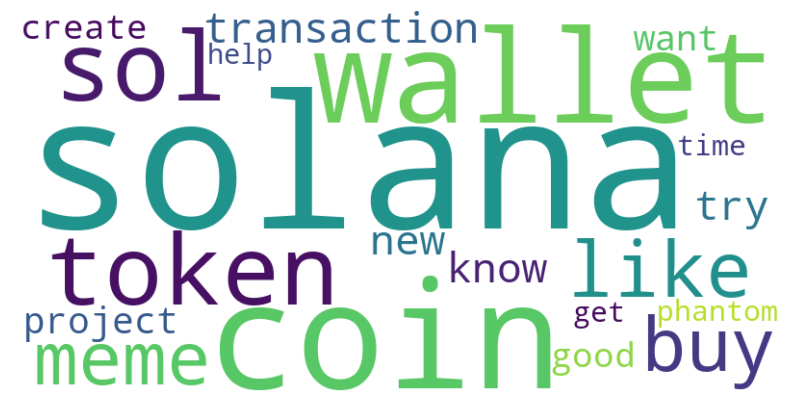

In [91]:
# Solana's word cloud
generate_word_cloud(common_words_solana)

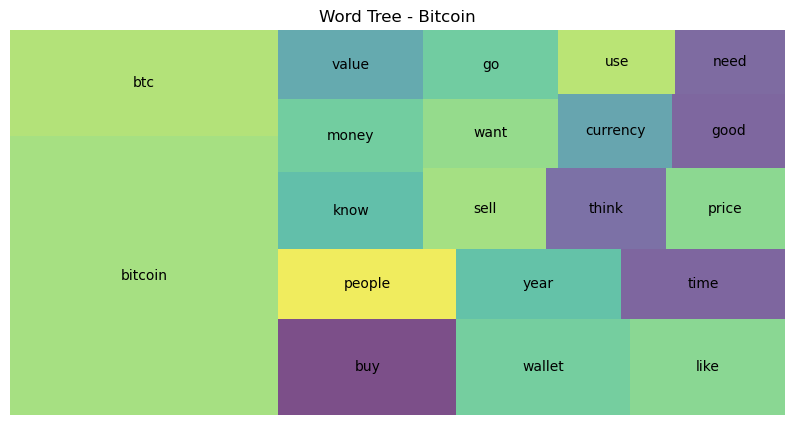

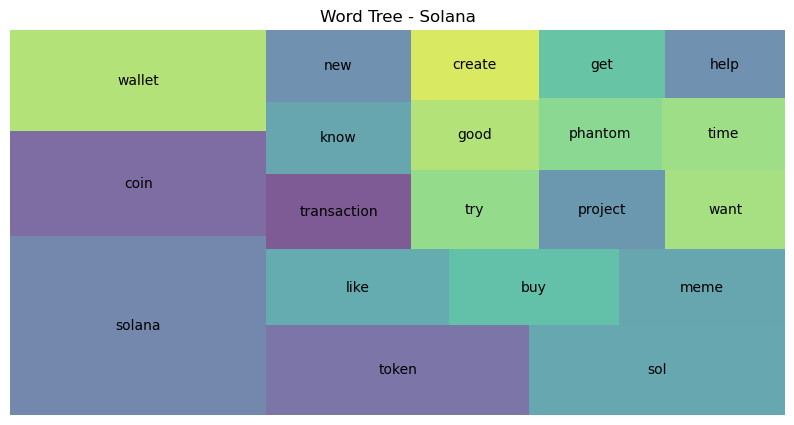

In [68]:
# function to generate word tree
def generate_word_tree(words, title):
    labels = words.index.tolist()  # Extracting words from the index
    sizes = words.values.tolist()  # Extracting frequencies from the values
    plt.figure(figsize=(10, 5))
    squarify.plot(sizes=sizes, label=labels, alpha=0.7)
    plt.axis('off')
    plt.title(title)

# Bitcoin and Solana word trees
generate_word_tree(common_words_bitcoin, 'Word Tree - Bitcoin')
generate_word_tree(common_words_solana, 'Word Tree - Solana')

Sentiment Analysis

In [1]:
# Check sentiment among both subreddits 

In [69]:
analizer = SentimentIntensityAnalyzer()

In [70]:
bitcoin_list = ''.join((new_df[new_df['subreddit'] == 'bitcoin']['title_text']).tolist())
solana_list = ''.join((new_df[new_df['subreddit'] == 'solana']['title_text']).tolist())

In [71]:
# calculate sentiment score for Bitcoin
bitcoin_scores = analizer.polarity_scores(bitcoin_list)
bitcoin_scores

{'neg': 0.098, 'neu': 0.695, 'pos': 0.208, 'compound': 1.0}

In [72]:
bitcoin_scores = {'neg': 0.098, 'neu': 0.695, 'pos': 0.208, 'compound': 1.0}
sentiment_mapping = {'neg': 'negative', 'neu': 'neutral', 'pos': 'positive', 'compound': 'compound'}
bitcoin_scores = {sentiment_mapping[key]: value for key, value in bitcoin_scores.items()}
bitcoin_scores

{'negative': 0.098, 'neutral': 0.695, 'positive': 0.208, 'compound': 1.0}

In [110]:
# Deleting the 'compound' entry
bitcoin_scores.pop(sentiment_mapping['compound'], None)

1.0

In [73]:
# calculate sentiment score for Solana
solana_scores = analizer.polarity_scores(solana_list)
solana_scores

{'neg': 0.081, 'neu': 0.72, 'pos': 0.199, 'compound': 1.0}

In [107]:
solana_scores = {'neg': 0.081, 'neu': 0.72, 'pos': 0.199, 'compound': 1.0}
sentiment_mapping = {'neg': 'negative', 'neu': 'neutral', 'pos': 'positive', 'compound': 'compound'}
solana_scores = {sentiment_mapping[key]: value for key, value in solana_scores.items()}
solana_scores

{'negative': 0.081, 'neutral': 0.72, 'positive': 0.199, 'compound': 1.0}

In [108]:
# Deleting the 'compound' entry
solana_scores.pop(sentiment_mapping['compound'], None)

1.0

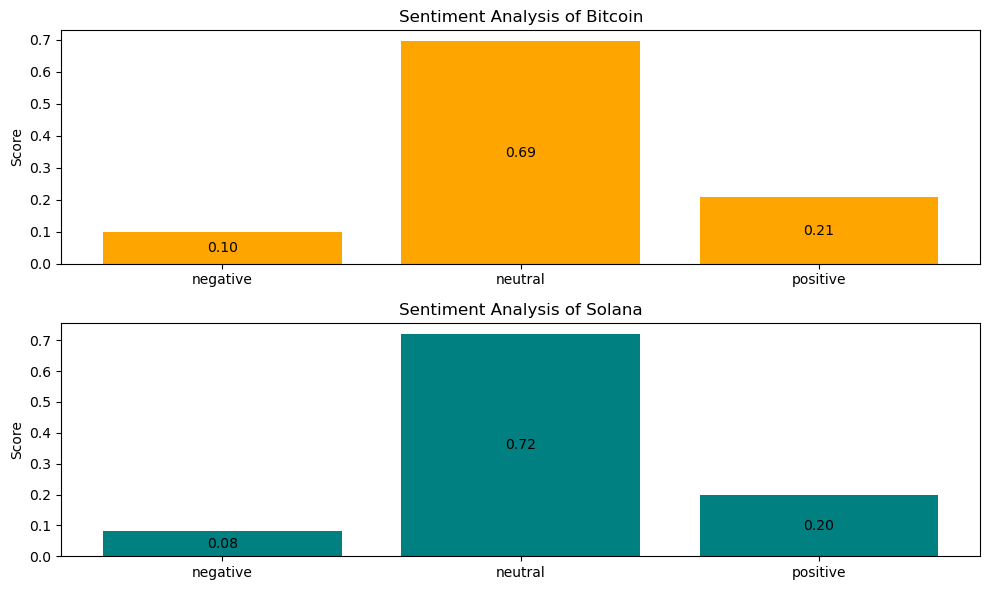

In [111]:
# Convert scores to a DataFrame for easier manipulation
scores_df = pd.DataFrame([bitcoin_scores, solana_scores], index=['Bitcoin', 'Solana'])

plt.figure(figsize=(10, 6))

# Plotting Bitcoin sentiment
plt.subplot(2, 1, 1)
bars = plt.bar(scores_df.columns, scores_df.loc['Bitcoin'], color='orange')
plt.title('Sentiment Analysis of Bitcoin')
plt.ylabel('Score')

# Add score numbers inside the bars for bitcoin 
for bar, score in zip(bars, scores_df.loc['Bitcoin']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{score:.2f}', ha='center', va='center', color='black')

# Plotting Solana sentiment
plt.subplot(2, 1, 2)
bars = plt.bar(scores_df.columns, scores_df.loc['Solana'], color='teal')
plt.title('Sentiment Analysis of Solana')
plt.ylabel('Score')

# Add score numbers inside the bars for solana
for bar, score in zip(bars, scores_df.loc['Solana']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{score:.2f}', ha='center', va='center', color='black')

plt.tight_layout()


Though both communities share a similar sentimen, it is slightly less negative among the Solana's community. 

### What words are more unique to one subreddit vs the other

In [76]:
# Tokenize the text and count the frequency of each word for Bitcoin subreddit
bitcoin_words = word_tokenize(bitcoin_list)
bitcoin_word_freq = Counter(bitcoin_words)

# Tokenize the text and count the frequency of each word for Solana subreddit
solana_words = word_tokenize(solana_list)
solana_word_freq = Counter(solana_words)

# Find the words more frequent in Bitcoin subreddit compared to Solana subreddit
bitcoin_unique_words = set(bitcoin_words) - set(solana_words)

# Find the words more frequent in Solana subreddit compared to Bitcoin subreddit
solana_unique_words = set(solana_words) - set(bitcoin_words)


In [77]:
top_words_to_display = 20 

print("Top", top_words_to_display, "words more frequent in Bitcoin subreddit:")
# Sort the unique Bitcoin words by frequency and print the top ones
bitcoin_top_words = sorted(bitcoin_unique_words, key=lambda word: bitcoin_word_freq[word], reverse=True)[:top_words_to_display]
print({word: bitcoin_word_freq[word] for word in bitcoin_top_words})

print("\nTop", top_words_to_display, "words more frequent in Solana subreddit:")
# Sort the unique Solana words by frequency and print the top ones
solana_top_words = sorted(solana_unique_words, key=lambda word: solana_word_freq[word], reverse=True)[:top_words_to_display]
print({word: solana_word_freq[word] for word in solana_top_words})

Top 20 words more frequent in Bitcoin subreddit:
{'etf': 76, 'storage': 41, 'satoshi': 34, 'custody': 31, 'sat': 28, 'bankman': 27, 'fried': 27, 'electrum': 24, 'utxo': 19, 'm2': 18, 'saylor': 18, 'argument': 18, 'bitcoiner': 17, 'p2p': 17, 'nation': 16, 'dca': 16, 'coldcard': 15, 'r': 15, 'valuable': 14, 'device': 14}

Top 20 words more frequent in Solana subreddit:
{'solana': 746, 'sol': 394, 'phantom': 148, 'memecoin': 113, 'jupiter': 94, 'raydium': 87, 'airdrop': 72, 'nft': 68, 'lp': 61, 'jup': 59, 'eth': 53, 'presale': 44, 'solflare': 43, 'validator': 35, 'bonkbot': 34, 'dexscreener': 28, 'marketing': 27, 'web3': 26, 'const': 25, 'solscan': 25}


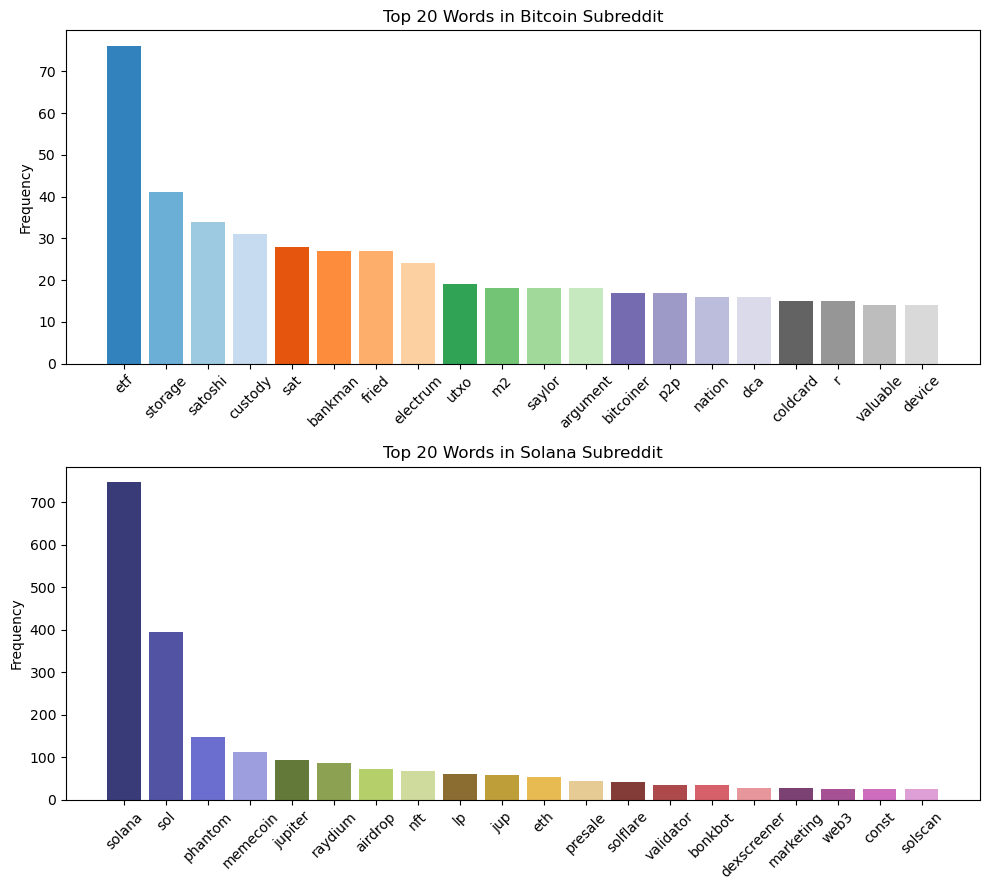

In [106]:
# Plotting
plt.figure(figsize=(10,9))

colormap = plt.cm.tab20c
colormap1 = plt.cm.tab20b

# Plot for Bitcoin subreddit
plt.subplot(2, 1, 1)
plt.bar(range(len(bitcoin_top_words)), [bitcoin_word_freq[word] for word in bitcoin_top_words], color=colormap(np.linspace(0, 1, len(common_words_bitcoin))))
plt.xticks(range(len(bitcoin_top_words)), bitcoin_top_words, rotation=45)
plt.ylabel('Frequency')
plt.title('Top 20 Words in Bitcoin Subreddit')

# Plot for Solana subreddit
plt.subplot(2, 1, 2)
plt.bar(range(len(solana_top_words)), [solana_word_freq[word] for word in solana_top_words], color=colormap1(np.linspace(0, 1, len(common_words_bitcoin))))
plt.xticks(range(len(solana_top_words)), solana_top_words, rotation=45)
plt.ylabel('Frequency')
plt.title('Top 20 Words in Solana Subreddit')

plt.tight_layout()

In [79]:
# checking specific words in the solana subreddit 
try:
    index = solana_list.index('bankman')
    print("This word is at index:", index)
except ValueError:
    print("This word is not in the list.")

# Counting the occurrences of the word "dca"
count = solana_list.count('bankman')
print("This word appears", count, "time(s) in the list.")

This word is not in the list.
This word appears 0 time(s) in the list.


In [80]:
try:
    index = solana_list.index('etf')
    print("This word is at index:", index)
except ValueError:
    print("This word is not in the list.")

# Counting the occurrences of the word "dca"
count = solana_list.count('etf')
print("This word appears", count, "time(s) in the list.")

This word is at index: 134753
This word appears 1 time(s) in the list.


Scam related topics are not part of the most commond discussions in the Solana subreddit which is positive for us. On the other hand, the conversation around ETFs, which is very popular among the Bitcoin community, is only mentioned once for Solana. We would like this word to appear more often as we want people to see Solana as a ./.......